In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Hyperparameters
batch_size = 128
latent_dim = 20
learning_rate = 1e-3
num_epochs = 20


In [ ]:
# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:01<00:00, 15.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.01MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 18.9MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2 * latent_dim)  # Mean and log variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)  # Split into mean and log variance
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [ ]:
# Loss Function: Reconstruction Loss + KL Divergence
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


In [ ]:
# Initialize model and optimizer
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# Training Loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Log training loss
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            val_loss += loss_function(recon_batch, data, mu, logvar).item()
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/20], Train Loss: 288.5663, Val Loss: 260.2799
Epoch [2/20], Train Loss: 253.7066, Val Loss: 252.5167
Epoch [3/20], Train Loss: 249.0107, Val Loss: 249.7934
Epoch [4/20], Train Loss: 246.6575, Val Loss: 247.8800
Epoch [5/20], Train Loss: 244.9714, Val Loss: 246.1583
Epoch [6/20], Train Loss: 243.7267, Val Loss: 245.2056
Epoch [7/20], Train Loss: 242.6057, Val Loss: 244.3237
Epoch [8/20], Train Loss: 241.7508, Val Loss: 243.1761
Epoch [9/20], Train Loss: 241.0811, Val Loss: 242.7553
Epoch [10/20], Train Loss: 240.6235, Val Loss: 242.2616
Epoch [11/20], Train Loss: 240.1756, Val Loss: 241.8122
Epoch [12/20], Train Loss: 239.7827, Val Loss: 241.9561
Epoch [13/20], Train Loss: 239.5129, Val Loss: 241.2243
Epoch [14/20], Train Loss: 239.1930, Val Loss: 241.2649
Epoch [15/20], Train Loss: 238.9872, Val Loss: 240.8737
Epoch [16/20], Train Loss: 238.7912, Val Loss: 240.8333
Epoch [17/20], Train Loss: 238.6226, Val Loss: 240.7474
Epoch [18/20], Train Loss: 238.4240, Val Loss: 240.4462
E

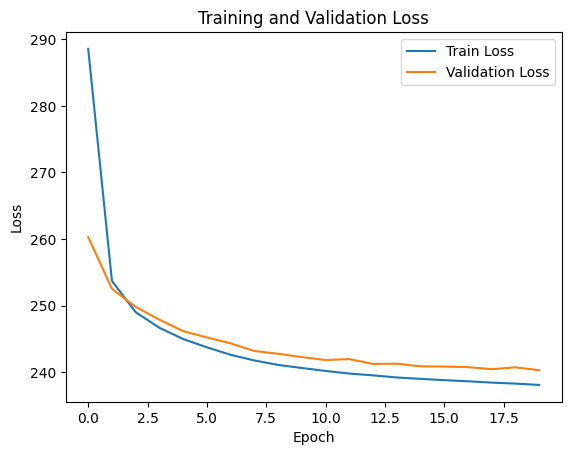

In [ ]:
# Plot Loss Curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


In [ ]:
# Reconstruct Test Images
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    recon_images, _, _ = model(test_images)


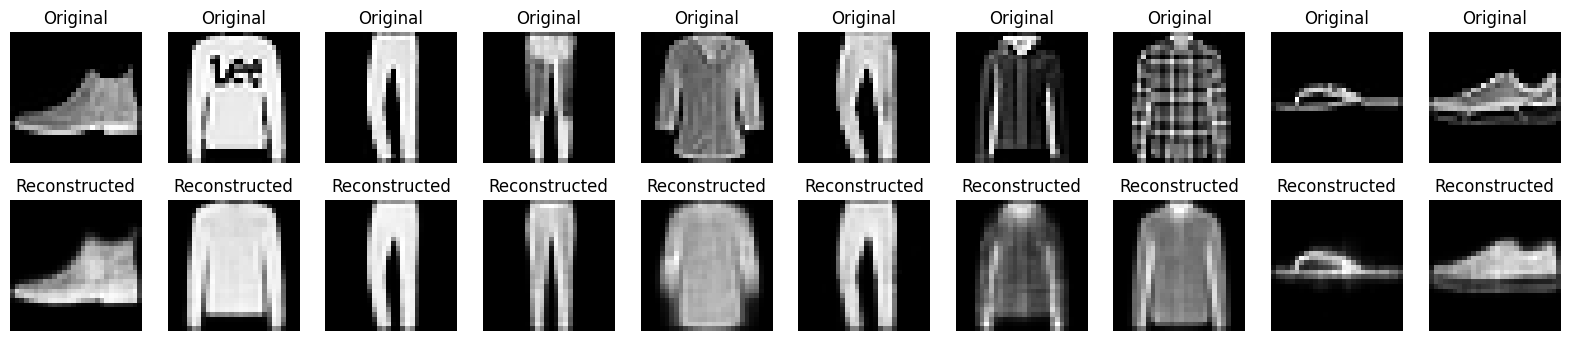

In [ ]:
# Plot Original vs Reconstructed Images
def show_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original Images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].cpu().view(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstructed Images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].cpu().view(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

show_images(test_images, recon_images)


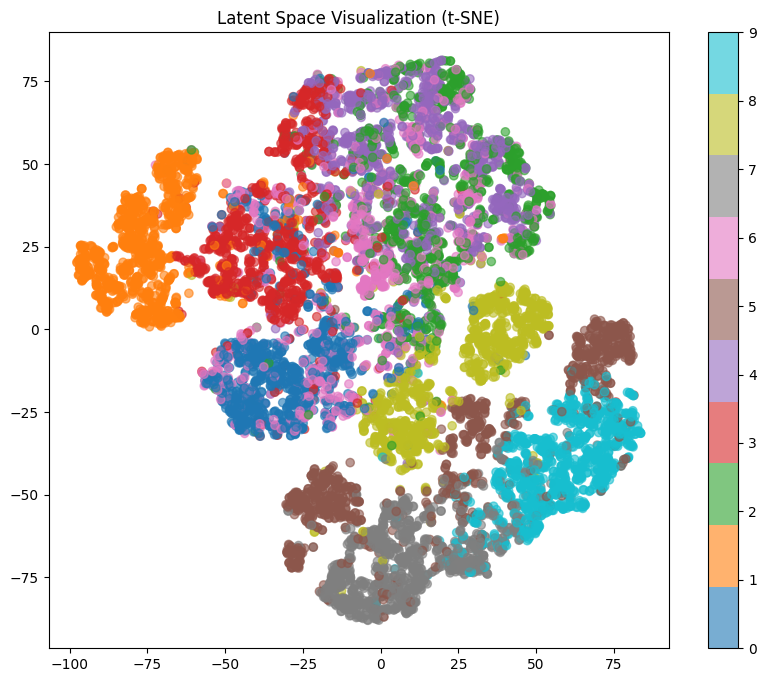

In [ ]:
# Latent Space Visualization (t-SNE)
def visualize_latent_space(model, data_loader, device):
    model.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            mu, _ = model.encoder(data.view(-1, 784)).chunk(2, dim=1)
            latent_vectors.append(mu.cpu())
            labels.append(label)
    latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="tab10", alpha=0.6)
    plt.colorbar(scatter)
    plt.title("Latent Space Visualization (t-SNE)")
    plt.show()

visualize_latent_space(model, test_loader, device)


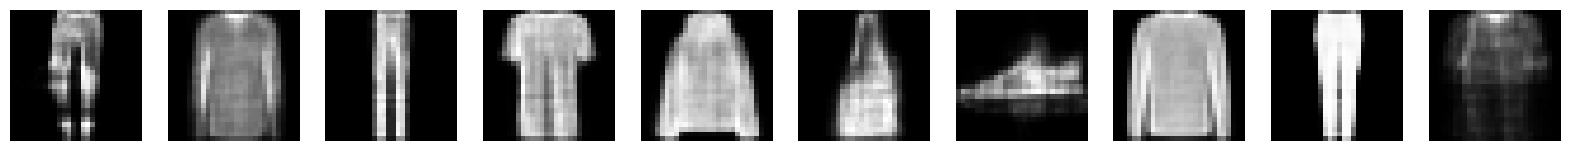

In [ ]:
# Generate New Images by Sampling from Latent Space
def generate_images(model, latent_dim, device, n=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, latent_dim).to(device)
        generated_images = model.decoder(z).cpu()
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i].view(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

generate_images(model, latent_dim, device)


In [ ]:
"""
1. The VAE successfully learns to reconstruct Fashion MNIST images.
2. The latent space visualization shows clustering of similar classes.
3. Generated images are realistic but slightly blurry due to the nature of VAEs.
4. Limitations: VAEs tend to produce blurry images compared to GANs.
5. Potential Improvements: Use a more complex architecture or hybrid models like VQ-VAE.
"""


'\n1. The VAE successfully learns to reconstruct Fashion MNIST images.\n2. The latent space visualization shows clustering of similar classes.\n3. Generated images are realistic but slightly blurry due to the nature of VAEs.\n4. Limitations: VAEs tend to produce blurry images compared to GANs.\n5. Potential Improvements: Use a more complex architecture or hybrid models like VQ-VAE.\n'